In [1]:
import sys
import os
from glob import glob

import scanpy as sc

import seaborn as sns

import pandas as pd
import numpy as np

import PyComplexHeatmap as ch

import matplotlib.pylab as plt

from sklearn.metrics import balanced_accuracy_score, f1_score, matthews_corrcoef, recall_score, precision_score

from pyprojroot import here

import warnings
warnings.filterwarnings("ignore")

sys.path.insert(1, str(here('bin')))

from customPythonFunctions import getClassMetricsDF

from customPalette import annotation_Level1_palette, annotation_Level1_LowQFilt_sortednames

from PyComplexHeatmap import *
import warnings

from customPalette import diseases_palette, diseaseCategories, diseasesGroup_palette


In [2]:
annotation_Level1_LowQFilt_sortednames

['B',
 'Plasma',
 'pDC',
 'DC',
 'Mono',
 'T_CD4_Naive',
 'T_CD4_NonNaive',
 'T_CD8_Naive',
 'T_CD8_NonNaive',
 'UTC',
 'ILC',
 'Cycling_cells',
 'Progenitors',
 'Platelets',
 'RBC']

In [3]:
cell_type_order = [c for c in annotation_Level1_LowQFilt_sortednames if c not in ['Cycling_cells','Progenitors','Platelets','RBC']]

In [4]:
optimization_metric = 'F1'

In [5]:
diseaseCategories['Na'] = 'Na'
diseasesGroup_palette['Na'] = '#ffffff'

### Computing additional metrics

In [6]:
def get_add_metric(disease_true, disease_pred):
    from sklearn.metrics import confusion_matrix
    
    disease_true = np.array(disease_true)
    disease_pred = np.array(disease_pred)
    res = []
    for d in np.unique(disease_true):
        support = (disease_true==d).sum()
        
        tn, fp, fn, tp = confusion_matrix(disease_true==d, disease_pred==d).ravel()
    
    
        prec = (tp / (tp+fp))
        recall = (tp / (tp+fn))
        specificity = (tn / (tn+fp))
        
        res.append([d, prec, recall, specificity, support])
    
    res = pd.DataFrame(res).fillna(0).set_index(0)
    Wprecision = np.average(res.loc[:,1], weights= res.loc[:,4])
    Wrecall = np.average(res.loc[:,2], weights= res.loc[:,4])
    Wspecifitity = np.average(res.loc[:,3], weights= res.loc[:,4])
    return (Wprecision,Wrecall,Wspecifitity)

### Loading results

In [7]:
metrics_df_path_list = glob(str(here(f'03_downstream_analysis/09_patient_classifier/5foldCV/results/CT_studies_predict/metrics_dataframes/METRICdf_SPLIT_*_opt{optimization_metric}.pkl')))
print(len(metrics_df_path_list))

5


In [8]:
scANVI_metrics_df_list = []

for p in metrics_df_path_list:
    scANVI_metrics_df_list.append(pd.read_pickle(p).rename({'F1':'W_F1'},axis=1))

*Keeping only the classifier that obtained the higher F1 score during the 5fold cross-validation*



In [9]:
scANVI_metrics__MajVote_df = pd.concat(scANVI_metrics_df_list, axis=0, ignore_index=True)

In [10]:
scANVI_metrics__MajVote_df.head()

,SPLIT,classification_method,W_F1,BAS,MCC,TRAIN_F1
0,1,LinearSVC,0.891012,0.882407,0.872455,0.684146
1,1,SVC,0.918005,0.851151,0.898244,0.714609
2,1,kNN,0.855961,0.819709,0.823917,0.652609
3,0,LinearSVC,0.878299,0.817546,0.844829,0.682622
4,0,SVC,0.890689,0.7908,0.879728,0.716603


In [11]:
scANVI_metrics__MajVote_df = scANVI_metrics__MajVote_df.loc[(scANVI_metrics__MajVote_df
                                             .groupby(['SPLIT',])['TRAIN_F1'].idxmax())]
scANVI_metrics__MajVote_df.drop('TRAIN_F1', axis=1,inplace=True)

#### Loading true and predicted labels

In [12]:
labels_df_dir= here(f'03_downstream_analysis/09_patient_classifier/5foldCV/results/CT_studies_predict/label_predicted_dataframes/')
label_df_path_list = []
for index, splt_i in scANVI_metrics__MajVote_df.iterrows():
    pt_i = os.path.join(labels_df_dir,f"{splt_i['classification_method']}_allCellType_SPLIT_{splt_i['SPLIT']}.pkl")
    lbl_df_i = pd.read_pickle(pt_i)
    lbl_df_i['SPLIT'] = splt_i['SPLIT']
    lbl_df_i.rename({'majority_pred':'Majority vote', 'disease':'disease_true'}, axis=1, inplace=True)
    
    lbl_df_i.columns = [c.replace('disease_pred_','') for c in lbl_df_i.columns]
    label_df_path_list.append(lbl_df_i)

labels_df = pd.concat(label_df_path_list, axis=0, ignore_index=False)

labels_df[labels_df.isna()] = 'Na'
labels_df[labels_df == 'nan'] = 'Na'

labels_df

,B,DC,ILC,Mono,Plasma,T_CD4_Naive,T_CD4_NonNaive,T_CD8_Naive,T_CD8_NonNaive,UTC,pDC,Majority vote,disease_true,SPLIT
sampleID,,,,,,,,,,,,,,
COMBAT2022_G05078_T0,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,0
COMBAT2022_G05105_T0,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,0
COMBAT2022_G05112_T0,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,0
COMBAT2022_G05171_T0,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,0
COMBAT2022_H00052_T0,sepsis,healthy,healthy,healthy,COVID,healthy,healthy,healthy,healthy,healthy,healthy,healthy,healthy,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Terekhova2023_FD04_T1,healthy,healthy,healthy,healthy,healthy,healthy,healthy,healthy,healthy,healthy,healthy,healthy,healthy,4
Wang2020_PID471_T0,HIV,healthy,healthy,healthy,SLE,healthy,healthy,healthy,healthy,healthy,cirrhosis,healthy,HIV,4
Zhang2023_P190808_T0,HBV,healthy,healthy,HBV,HBV,healthy,HBV,HBV,healthy,healthy,healthy,healthy,HBV,4


In [13]:
labels_df.index.unique().shape

(817,)

### Computing the number of pseudobulk for disease stratified by cell-types and split

In [14]:
cell_classification_df = pd.concat(label_df_path_list, axis=0, ignore_index=False).drop(['Majority vote'], axis=1)
cell_classification_df

,B,DC,ILC,Mono,Plasma,T_CD4_Naive,T_CD4_NonNaive,T_CD8_Naive,T_CD8_NonNaive,UTC,pDC,disease_true,SPLIT
sampleID,,,,,,,,,,,,,
COMBAT2022_G05078_T0,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,0
COMBAT2022_G05105_T0,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,0
COMBAT2022_G05112_T0,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,0
COMBAT2022_G05171_T0,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,0
COMBAT2022_H00052_T0,sepsis,healthy,healthy,healthy,COVID,healthy,healthy,healthy,healthy,healthy,healthy,healthy,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Terekhova2023_FD04_T1,healthy,healthy,healthy,healthy,healthy,healthy,healthy,healthy,healthy,healthy,healthy,healthy,4
Wang2020_PID471_T0,HIV,healthy,healthy,healthy,SLE,healthy,healthy,healthy,healthy,healthy,cirrhosis,HIV,4
Zhang2023_P190808_T0,HBV,healthy,healthy,HBV,HBV,healthy,HBV,HBV,healthy,healthy,healthy,HBV,4


In [15]:
cell_classification_df.columns

Index(['B', 'DC', 'ILC', 'Mono', 'Plasma', 'T_CD4_Naive', 'T_CD4_NonNaive',
       'T_CD8_Naive', 'T_CD8_NonNaive', 'UTC', 'pDC', 'disease_true', 'SPLIT'],
      dtype='object')

In [16]:
pseudobulk_disease_mtx  = (cell_classification_df.reset_index()
                          .melt(id_vars = ['sampleID','disease_true'], 
                                value_vars=['B', 'DC', 'ILC', 'Mono', 'Plasma', 'T_CD4_Naive', 'T_CD4_NonNaive','T_CD8_Naive', 'T_CD8_NonNaive', 'UTC', 'pDC'], 
                                var_name='cell-type')
                          .dropna(axis=0, how='any').drop(['value'], axis=1)
                          .groupby(['disease_true','cell-type'])
                          .count().reset_index()
                          .pivot(index=['disease_true'], columns='cell-type')
                         )

pseudobulk_disease_mtx

sampleID                                                   \
cell-type           B   DC  ILC Mono Plasma T_CD4_Naive T_CD4_NonNaive   
disease_true                                                             
BRCA                6    6    6    6      6           6              6   
CD                 21   21   21   21     18          21             21   
COPD               12   12   12   12     11          12             12   
COVID             117  111  117  117    112         117            117   
CRC                14   14   14   14     14          14             14   
HBV                15   14   15   15     15          15             15   
HIV                 6    6    6    6      6           6              6   
HNSCC              21   21   21   21     16          21             21   
MS                  5    5    5    5      5           5              5   
NPC                10   10   10   10     10          10             10   
PS                 26   26   26   26     21          26             26   
PSA                26   26   26   26     23          26             26   
RA                 38   38   38   38     37          38             38   
SLE               140  140  142  142    111         142            142   
UC                 22   22   22   22     21          22             22   
asthma             12   12   12   12     12          12             12   
cirrhosis           8    8    8    8      8           8              8   
flu                11    8   11   11     10          10             11   
healthy           270  270  270  270    248         270            270   
sepsis             34   29   35   35     24          30             34   

                                                   
cell-type    T_CD8_Naive T_CD8_NonNaive  UTC  pDC  
disease_true                                       
BRCA                   6              6    6    6  
CD                    21             21   21   21  
COPD                  12             12   12   12  
COVID                117            117  116   99  
CRC                   14             14   14   14  
HBV                   15             15   15   14  
HIV                    6              6    6    3  
HNSCC                 21             21   21   20  
MS                     5              5    5    5  
NPC                   10             10   10   10  
PS                    26             26   24   26  
PSA                   26             26   24   26  
RA                    38             38   37   38  
SLE                  142            142  142  139  
UC                    22             22   21   20  
asthma                12             12   12   12  
cirrhosis              8              8    8    8  
flu                    9             11    9    9  
healthy              268            270  270  268  
sepsis                24             35   34   25

In [17]:
pseudobulk_disease_mtx.div(pseudobulk_disease_mtx.max(axis=1), axis='rows')

sampleID                                            \
cell-type            B        DC  ILC Mono    Plasma T_CD4_Naive   
disease_true                                                       
BRCA          1.000000  1.000000  1.0  1.0  1.000000    1.000000   
CD            1.000000  1.000000  1.0  1.0  0.857143    1.000000   
COPD          1.000000  1.000000  1.0  1.0  0.916667    1.000000   
COVID         1.000000  0.948718  1.0  1.0  0.957265    1.000000   
CRC           1.000000  1.000000  1.0  1.0  1.000000    1.000000   
HBV           1.000000  0.933333  1.0  1.0  1.000000    1.000000   
HIV           1.000000  1.000000  1.0  1.0  1.000000    1.000000   
HNSCC         1.000000  1.000000  1.0  1.0  0.761905    1.000000   
MS            1.000000  1.000000  1.0  1.0  1.000000    1.000000   
NPC           1.000000  1.000000  1.0  1.0  1.000000    1.000000   
PS            1.000000  1.000000  1.0  1.0  0.807692    1.000000   
PSA           1.000000  1.000000  1.0  1.0  0.884615    1.000000   
RA            1.000000  1.000000  1.0  1.0  0.973684    1.000000   
SLE           0.985915  0.985915  1.0  1.0  0.781690    1.000000   
UC            1.000000  1.000000  1.0  1.0  0.954545    1.000000   
asthma        1.000000  1.000000  1.0  1.0  1.000000    1.000000   
cirrhosis     1.000000  1.000000  1.0  1.0  1.000000    1.000000   
flu           1.000000  0.727273  1.0  1.0  0.909091    0.909091   
healthy       1.000000  1.000000  1.0  1.0  0.918519    1.000000   
sepsis        0.971429  0.828571  1.0  1.0  0.685714    0.857143   

                                                                            
cell-type    T_CD4_NonNaive T_CD8_Naive T_CD8_NonNaive       UTC       pDC  
disease_true                                                                
BRCA               1.000000    1.000000            1.0  1.000000  1.000000  
CD                 1.000000    1.000000            1.0  1.000000  1.000000  
COPD               1.000000    1.000000            1.0  1.000000  1.000000  
COVID              1.000000    1.000000            1.0  0.991453  0.846154  
CRC                1.000000    1.000000            1.0  1.000000  1.000000  
HBV                1.000000    1.000000            1.0  1.000000  0.933333  
HIV                1.000000    1.000000            1.0  1.000000  0.500000  
HNSCC              1.000000    1.000000            1.0  1.000000  0.952381  
MS                 1.000000    1.000000            1.0  1.000000  1.000000  
NPC                1.000000    1.000000            1.0  1.000000  1.000000  
PS                 1.000000    1.000000            1.0  0.923077  1.000000  
PSA                1.000000    1.000000            1.0  0.923077  1.000000  
RA                 1.000000    1.000000            1.0  0.973684  1.000000  
SLE                1.000000    1.000000            1.0  1.000000  0.978873  
UC                 1.000000    1.000000            1.0  0.954545  0.909091  
asthma             1.000000    1.000000            1.0  1.000000  1.000000  
cirrhosis          1.000000    1.000000            1.0  1.000000  1.000000  
flu                1.000000    0.818182            1.0  0.818182  0.818182  
healthy            1.000000    0.992593            1.0  1.000000  0.992593  
sepsis             0.971429    0.685714            1.0  0.971429  0.714286

In [18]:
scANVI_metrics__MajVote_df

,SPLIT,classification_method,W_F1,BAS,MCC
4,0,SVC,0.890689,0.7908,0.879728
1,1,SVC,0.918005,0.851151,0.898244
7,2,SVC,0.95559,0.966204,0.94172
10,3,SVC,0.887765,0.836052,0.857983
13,4,SVC,0.868233,0.799735,0.847812


In [19]:
scANVI_metrics__MajVote_df[['W_precision','W_recall','W_specificity']] = 0

In [20]:
for s in labels_df.SPLIT.unique():
    S_i = labels_df.query("SPLIT == @s")
    Wprecision_i, Wrecall_i, Wspecifitity_i = get_add_metric(disease_pred=S_i['Majority vote'], disease_true= S_i.disease_true)
    scANVI_metrics__MajVote_df.loc[scANVI_metrics__MajVote_df['SPLIT'] == s,'W_precision']=Wprecision_i
    scANVI_metrics__MajVote_df.loc[scANVI_metrics__MajVote_df['SPLIT'] == s,'W_recall']=Wrecall_i
    scANVI_metrics__MajVote_df.loc[scANVI_metrics__MajVote_df['SPLIT'] == s,'W_specificity']=Wspecifitity_i

In [21]:
scANVI_metrics__MajVote_df

,SPLIT,classification_method,W_F1,BAS,MCC,W_precision,W_recall,W_specificity
4,0,SVC,0.890689,0.7908,0.879728,0.898510,0.898810,0.982625
1,1,SVC,0.918005,0.851151,0.898244,0.934678,0.914634,0.992141
7,2,SVC,0.95559,0.966204,0.94172,0.967052,0.950617,0.996803
10,3,SVC,0.887765,0.836052,0.857983,0.909754,0.881250,0.985865
13,4,SVC,0.868233,0.799735,0.847812,0.888099,0.871166,0.983031


**Metrics averaged over 5 splits**

In [22]:
scANVI_metrics__MajVote_df[['W_F1','BAS','MCC','W_precision','W_recall','W_specificity']].mean()

W_F1             0.904056
BAS              0.848788
MCC              0.885098
W_precision      0.919618
W_recall         0.903295
W_specificity    0.988093
dtype: object

In [23]:
scANVI_metrics__MajVote_df[['W_F1','BAS','MCC','W_precision','W_recall','W_specificity']].std()

W_F1             0.033829
BAS              0.070219
MCC              0.037193
W_precision      0.031674
W_recall          0.03125
W_specificity    0.006179
dtype: object

**Considering 817 samples**

In [24]:
print(f"Majority Voting BAS: {balanced_accuracy_score(y_pred=labels_df['Majority vote'], y_true=labels_df.disease_true)}")
print(f"Majority Voting Weighetd F1: {f1_score(y_pred=labels_df['Majority vote'], y_true=labels_df.disease_true, average='weighted')}")
print(f"Majority Voting MCC: {matthews_corrcoef(y_pred=labels_df['Majority vote'], y_true=labels_df.disease_true)}")

# Additional metrics
Wprecision,Wrecall,Wspecifitity = get_add_metric(disease_pred=labels_df['Majority vote'], disease_true= labels_df.disease_true)

print(f"Majority Voting Weighet precision: {Wprecision}")
print(f"Majority Voting Weighet recall: {Wrecall}")
print(f"Majority Voting Weighet specificity: {Wspecifitity}")

Majority Voting BAS: 0.845201895097188
Majority Voting Weighetd F1: 0.906559967873813
Majority Voting MCC: 0.8845469649593592
Majority Voting Weighet precision: 0.9155731110934868
Majority Voting Weighet recall: 0.9033047735618115
Majority Voting Weighet specificity: 0.9879633924402473


**Plasma and UTC**

In [25]:
print(f"Plasma BAS: {balanced_accuracy_score(y_pred=labels_df['Plasma'].astype(str), y_true=labels_df.disease_true.astype(str))}")
print(f"Plasma Weighetd F1: {f1_score(y_pred=labels_df['Plasma'].astype(str), y_true=labels_df.disease_true.astype(str), average='weighted')}")

print(f"UTC BAS: {balanced_accuracy_score(y_pred=labels_df['UTC'].astype(str), y_true=labels_df.disease_true.astype(str))}")
print(f"UTC Weighetd F1: {f1_score(y_pred=labels_df['UTC'].astype(str), y_true=labels_df.disease_true.astype(str), average='weighted')}")

Plasma BAS: 0.5316835363453227
Plasma Weighetd F1: 0.6444055825644621
UTC BAS: 0.6668780642112739
UTC Weighetd F1: 0.7843318035647588


In [26]:
labels_df.loc['Reyes2020_C2P16_T0']

B                  sepsis
DC                 sepsis
ILC               healthy
Mono               sepsis
Plasma                 Na
T_CD4_Naive       healthy
T_CD4_NonNaive     sepsis
T_CD8_Naive            Na
T_CD8_NonNaive    healthy
UTC               healthy
pDC                sepsis
Majority vote      sepsis
disease_true       sepsis
SPLIT                   2
Name: Reyes2020_C2P16_T0, dtype: object

In [27]:
labels_df['Majority vote'].unique()

array(['COVID', 'healthy', 'sepsis', 'HNSCC', 'NPC', 'SLE', 'Na', 'UC',
       'CD', 'PS', 'RA', 'PSA', 'asthma', 'COPD', 'BRCA', 'CRC',
       'cirrhosis', 'MS', 'HIV', 'HBV', 'flu'], dtype=object)

In [28]:
labels_df.head(3)

,B,DC,ILC,Mono,Plasma,T_CD4_Naive,T_CD4_NonNaive,T_CD8_Naive,T_CD8_NonNaive,UTC,pDC,Majority vote,disease_true,SPLIT
sampleID,,,,,,,,,,,,,,
COMBAT2022_G05078_T0,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,0
COMBAT2022_G05105_T0,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,0
COMBAT2022_G05112_T0,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,COVID,0


In [29]:
labels_df.columns

Index(['B', 'DC', 'ILC', 'Mono', 'Plasma', 'T_CD4_Naive', 'T_CD4_NonNaive',
       'T_CD8_Naive', 'T_CD8_NonNaive', 'UTC', 'pDC', 'Majority vote',
       'disease_true', 'SPLIT'],
      dtype='object')

In [30]:
labelsMelt = labels_df.melt(value_vars = ['B', 'DC', 'ILC', 'Mono', 'Plasma', 'T_CD4_Naive', 'T_CD4_NonNaive',
                                          'T_CD8_Naive', 'T_CD8_NonNaive', 'UTC', 'pDC', 'Majority vote'], 
                            id_vars = ['SPLIT','disease_true'], 
                            var_name = 'cell_type', value_name= 'disease_pred', ignore_index=False).reset_index()
labelsMelt['disease_true'] = labelsMelt['disease_true'].astype(str)
labelsMelt

,sampleID,SPLIT,disease_true,cell_type,disease_pred
0,COMBAT2022_G05078_T0,0,COVID,B,COVID
1,COMBAT2022_G05105_T0,0,COVID,B,COVID
2,COMBAT2022_G05112_T0,0,COVID,B,COVID
3,COMBAT2022_G05171_T0,0,COVID,B,COVID
4,COMBAT2022_H00052_T0,0,healthy,B,sepsis
...,...,...,...,...,...
9799,Terekhova2023_FD04_T1,4,healthy,Majority vote,healthy
9800,Wang2020_PID471_T0,4,HIV,Majority vote,healthy
9801,Zhang2023_P190808_T0,4,HBV,Majority vote,healthy
9802,Zhang2023_P191028_T0,4,HBV,Majority vote,HBV


In [31]:
print(f"overall BAS for cell-type: {balanced_accuracy_score(labelsMelt.loc[labelsMelt['cell_type'] != 'Majority vote','disease_true'].astype(str),labelsMelt.loc[labelsMelt['cell_type'] != 'Majority vote','disease_pred'].astype(str))}")

print(f"overall W F1 for cell-type: {f1_score(labelsMelt.loc[labelsMelt['cell_type'] != 'Majority vote','disease_true'].astype(str), labelsMelt.loc[labelsMelt['cell_type'] != 'Majority vote','disease_pred'].astype(str), average='weighted')}")

print(f"overall MCC for cell-type: {matthews_corrcoef(labelsMelt.loc[labelsMelt['cell_type'] != 'Majority vote','disease_true'].astype(str),labelsMelt.loc[labelsMelt['cell_type'] != 'Majority vote','disease_pred'].astype(str))}")



overall BAS for cell-type: 0.7391927107318981
overall W F1 for cell-type: 0.8218406346025086
overall MCC for cell-type: 0.7792018046511165


In [32]:
print(f" Number of patients that were not classified due to undetermined majority vote result: {(labels_df['Majority vote'] == 'Na').sum()}")

 Number of patients that were not classified due to undetermined majority vote result: 10


### Weighted F1, Balanced Accuracy Score, Matthew coefficent score

We compute those metrics for each cell-type, balacing the conditions

In [33]:
cell_type_WF1 = (labelsMelt.groupby(['SPLIT','cell_type'])[['disease_true','disease_pred']]
                 .apply(lambda x: (f1_score(x.disease_true.astype(str),
                                           x.disease_pred.astype(str), average='weighted')))
                ).reset_index()
cell_type_WF1.rename({0:'W_F1'}, axis = 1, inplace=True)

In [34]:
cell_type_bas = (labelsMelt.groupby(['SPLIT','cell_type'])[['disease_true','disease_pred']]
                 .apply(lambda x: (balanced_accuracy_score(x.disease_true.astype(str), 
                                                           x.disease_pred.astype(str))))
                ).reset_index()
cell_type_bas.rename({0:'BAS'}, axis = 1, inplace=True)


In [35]:
cell_type_mcc = (labelsMelt.groupby(['SPLIT','cell_type'])[['disease_true','disease_pred']]
                 .apply(lambda x: (matthews_corrcoef(x.disease_true.astype(str), 
                                                           x.disease_pred.astype(str))))
                ).reset_index()
cell_type_mcc.rename({0:'MCC'}, axis = 1, inplace=True)

### F1, Precision, Recall

We compute those metrics for each cell-type and each condition 

In [36]:
cell_type_F1 = (labelsMelt.groupby(['cell_type'])[['disease_true','disease_pred']]
                 .apply(lambda x: (f1_score(y_true = x.disease_true.astype(str), 
                                            y_pred = x.disease_pred.astype(str), 
                                            labels=x.disease_true.unique(), average=None)))
                ).reset_index()
cell_type_F1.columns = ['cell_type','F1']
cell_type_F1['disease_true'] = [labelsMelt.disease_true.unique().tolist()]*cell_type_F1.shape[0]
cell_type_F1 = cell_type_F1.explode(['F1','disease_true'])

In [37]:
cell_type_recall = (labelsMelt.groupby(['cell_type'])[['disease_true','disease_pred']]
                 .apply(lambda x: (recall_score(y_true = x.disease_true.astype(str), 
                                            y_pred = x.disease_pred.astype(str), labels=x.disease_true.unique(), average=None)))
                ).reset_index()
cell_type_recall.columns = ['cell_type','recall']
cell_type_recall['disease_true'] = [labelsMelt.disease_true.unique().tolist()]*cell_type_recall.shape[0]
cell_type_recall = cell_type_recall.explode(['recall','disease_true'])

In [38]:
cell_type_precision = (labelsMelt.groupby(['cell_type'])[['disease_true','disease_pred']]
                 .apply(lambda x: (precision_score(y_true = x.disease_true.astype(str), 
                                                   y_pred = x.disease_pred.astype(str), labels=x.disease_true.unique(), average=None)))
                ).reset_index()
cell_type_precision.columns = ['cell_type','precision']
cell_type_precision['disease_true'] = [labelsMelt.disease_true.unique().tolist()]*cell_type_precision.shape[0]
cell_type_precision = cell_type_precision.explode(['precision','disease_true'])

## Visualization

In [39]:
# ordering elements
labelsMelt.disease_pred = labelsMelt.disease_pred.astype(str)
labelsMelt.disease_pred[labelsMelt.disease_pred == 'nan'] = 'Na'

# labelsMelt = labelsMelt.query("disease_pred != 'Na'")

elementList =  [d for d in set(labelsMelt.disease_true.tolist() + labelsMelt.disease_pred.tolist()) if (d != 'healthy' and d!='Na')]
diseaseCatOrd = [diseaseCategories[d] for d in elementList]

sortedIdx = sorted(range(len(diseaseCatOrd)), key=lambda index: diseaseCatOrd[index])
# elementList = ['healthy'] + [elementList[i] for i in sortedIdx] #+ ['NA']
# diseaseCatOrd = ['healthy'] + [diseaseCatOrd[i] for i in sortedIdx] #+ ['NA']

disease_cat_ordDF = pd.DataFrame.from_dict({'elementList':elementList,'diseaseCatOrd':[diseaseCategories[d] for d in elementList]})
disease_cat_ordDF = pd.concat((pd.DataFrame.from_dict({'elementList':['healthy'], 'diseaseCatOrd':['healthy']}), 
                               disease_cat_ordDF.iloc[sortedIdx,:].groupby('diseaseCatOrd').apply(lambda x: x.sort_values('elementList')).reset_index(drop=True),
                              pd.DataFrame.from_dict({'elementList':['Na'], 'diseaseCatOrd':['Na']})),
                              axis=0)

**Distribution over 5 splits**

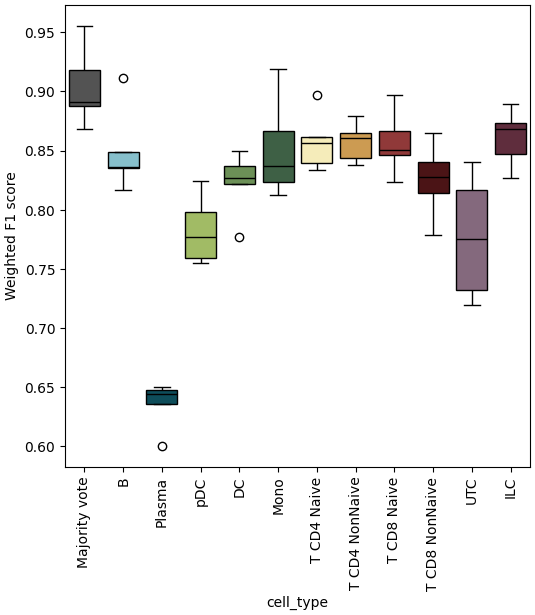

In [40]:
plt.figure(figsize=(6,6))
g = sns.boxplot(cell_type_WF1, 
            x = 'cell_type', 
            hue = 'cell_type', 
            y = 'W_F1', 
            palette  = annotation_Level1_palette | {'Majority vote':'#535353'},
               order=['Majority vote'] + cell_type_order)
plt.ylabel('Weighted F1 score')

g.set_xticks(g.get_xticks(), [t.get_text().replace('_',' ') for t in g.get_xticklabels()])

# plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=2, fancybox=True)
plt.xticks(rotation=90)

plt.savefig(here("03_downstream_analysis/09_patient_classifier/5foldCV/results/figures/referencebalanced_WF1_CTxDisease.pdf"),
dpi=300,
bbox_inches='tight',
pad_inches=0.1
)
plt.show()

In [41]:
from sklearn.metrics import balanced_accuracy_score, f1_score, confusion_matrix
corrData = pd.read_pickle(here('03_downstream_analysis/08_gene_importance/results/xgboost_aggregated_predictions.pkl'))
corrData = corrData.rename({'y_true':'disease', 'y_pred':'disease_pred','cell_type':'Level1'}, axis=1)
corrData
WF1_CT = corrData.groupby(['Level1'])[['disease','disease_pred']].apply(lambda x: (f1_score(y_true = x.disease.astype(str),
                                                                                   y_pred = x.disease_pred.astype(str),
                                                                                   average='weighted')))
WF1_CT

Level1
B                 0.878075
DC                0.904717
ILC               0.875045
Mono              0.923040
Plasma            0.803823
T_CD4_Naive       0.894848
T_CD4_NonNaive    0.917895
T_CD8_Naive       0.912580
T_CD8_NonNaive    0.881929
UTC               0.901246
pDC               0.914586
dtype: float64

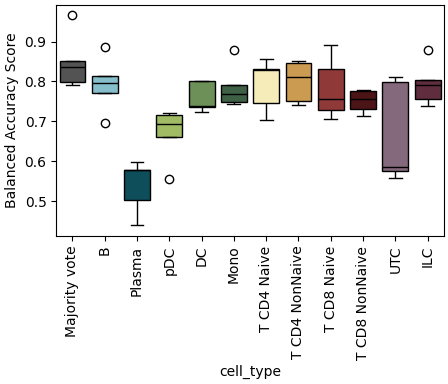

In [42]:
plt.figure(figsize=(5,3))
g = sns.boxplot(cell_type_bas, 
            x = 'cell_type', 
            hue = 'cell_type', 
            y = 'BAS', 
            palette  = annotation_Level1_palette | {'Majority vote':'#535353'},
               order=['Majority vote'] + cell_type_order)
plt.ylabel('Balanced Accuracy Score')
g.set_xticks(g.get_xticks(), [t.get_text().replace('_',' ') for t in g.get_xticklabels()])

# plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=2, fancybox=True)
plt.xticks(rotation=90)

plt.savefig(here("03_downstream_analysis/09_patient_classifier/5foldCV/results/figures/referencebalanced_BAS_CTxDisease.pdf"),
dpi=300,
bbox_inches='tight',
pad_inches=0.1
)
plt.show()

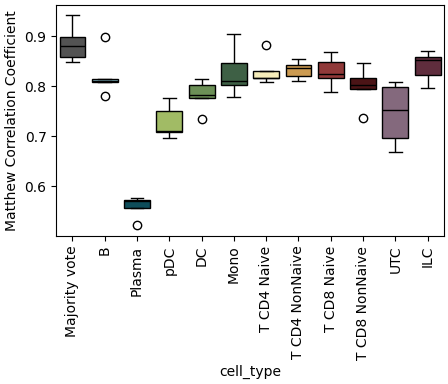

In [112]:
plt.figure(figsize=(5,3))
g = sns.boxplot(cell_type_mcc, 
            x = 'cell_type', 
            hue = 'cell_type', 
            y = 'MCC', 
            palette  = annotation_Level1_palette | {'Majority vote':'#535353'},
               order=['Majority vote'] + cell_type_order)

g.set_xticks(g.get_xticks(), [t.get_text().replace('_',' ') for t in g.get_xticklabels()])

plt.ylabel('Matthew Correlation Coefficient')
# plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=2, fancybox=True)
plt.xticks(rotation=90)

plt.savefig(here("03_downstream_analysis/09_patient_classifier/5foldCV/results/figures/referencebalanced_MCC_CTxDisease.pdf"),
dpi=300,
bbox_inches='tight',
pad_inches=0.1
)
plt.show()

**Score for each cell-type and disease**

after aggregating the prediction on each left-out split 

In [43]:
cell_type_F1

,cell_type,F1,disease_true
0,B,0.954357,COVID
0,B,0.859287,healthy
0,B,0.676056,sepsis
0,B,0.47619,flu
0,B,0.926829,HNSCC
...,...,...,...
11,pDC,0.666667,cirrhosis
11,pDC,0.846154,CRC
11,pDC,0.5,MS
11,pDC,0.285714,HIV


In [45]:
cell_type_F1.query("cell_type.isin(['DC','pDC']) & disease_true == 'HIV'")

,cell_type,F1,disease_true
1,DC,0.285714,HIV
11,pDC,0.285714,HIV


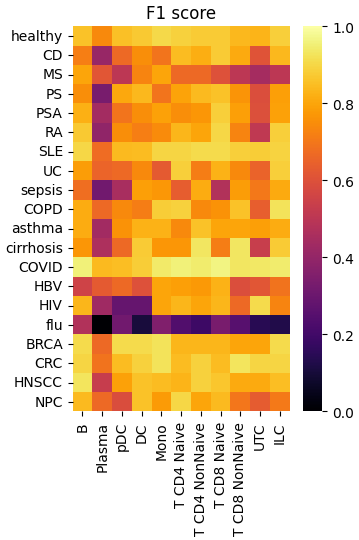

In [114]:
data = cell_type_F1.query("cell_type != 'Majority vote'").pivot(columns='disease_true', index = 'cell_type', values = 'F1').T.fillna(0)

plt.figure(figsize=(3.5,5))

g = sns.heatmap(data.loc[disease_cat_ordDF.elementList[disease_cat_ordDF.elementList.isin(data.index.tolist())],
                cell_type_order],vmin=0,vmax=1,cmap='inferno')

g.set_xticks(g.get_xticks(), [t.get_text().replace('_',' ') for t in g.get_xticklabels()])

g.set_title('F1 score')
g.set_xlabel("")
g.set_ylabel("")

plt.savefig(here(f"03_downstream_analysis/09_patient_classifier/5foldCV/results/figures/clusterMap_F1_CTxDisease_noMV.pdf"),
dpi=300,
bbox_inches='tight',
pad_inches=0.1
)

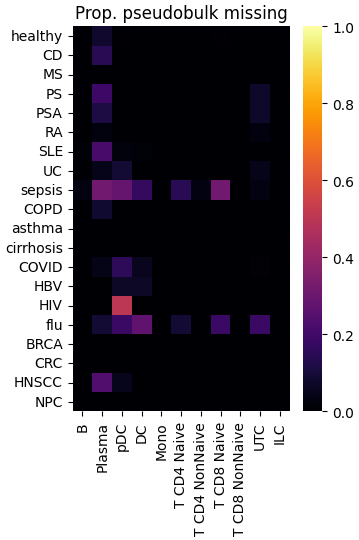

In [152]:
data_nPB_D = pseudobulk_disease_mtx.div(pseudobulk_disease_mtx.max(axis=1), axis='rows')
data_nPB_D = 1 - data_nPB_D.T.reset_index().drop(['level_0'], axis=1).set_index('cell-type').T
plt.figure(figsize=(3.5,5))

g = sns.heatmap(data_nPB_D.loc[disease_cat_ordDF.elementList[disease_cat_ordDF.elementList.isin(data_nPB_D.index.tolist())],
                cell_type_order],vmin=0,vmax=1,cmap='inferno')

g.set_xticks(g.get_xticks(), [t.get_text().replace('_',' ') for t in g.get_xticklabels()])

g.set_title('Prop. pseudobulk missing')
g.set_xlabel("")
g.set_ylabel("")

plt.savefig(here(f"03_downstream_analysis/09_patient_classifier/5foldCV/results/figures/prop_num_pseudobulk_disease.pdf"),
dpi=300,
bbox_inches='tight',
pad_inches=0.1
)



In [151]:
from scipy.stats import spearmanr, pearsonr

pearsonr(cell_type_WF1.groupby('cell_type')['W_F1'].mean().drop('Majority vote',axis=0), 
         data_nPB_D.mean(axis=0))

PearsonRResult(statistic=-0.8359279843276451, pvalue=0.0013483360051036095)

In [42]:
cell_type_F1.query("cell_type in ['T_CD4_Naive','T_CD8_Naive','B'] and disease_true in ['HIV']")

,cell_type,F1,disease_true
0,B,0.833333,HIV
6,T_CD4_Naive,0.833333,HIV
8,T_CD8_Naive,0.833333,HIV


In [43]:
cell_type_F1.query("cell_type in ['DC','pDC'] and disease_true in ['HIV']")

,cell_type,F1,disease_true
1,DC,0.285714,HIV
11,pDC,0.285714,HIV


In [44]:
cell_type_precision.query("cell_type in ['DC','pDC'] and disease_true in ['HIV']")

,cell_type,precision,disease_true
1,DC,1.0,HIV
11,pDC,1.0,HIV


In [45]:
cell_type_recall.query("cell_type in ['DC','pDC'] and disease_true in ['HIV']")

,cell_type,recall,disease_true
1,DC,0.166667,HIV
11,pDC,0.166667,HIV


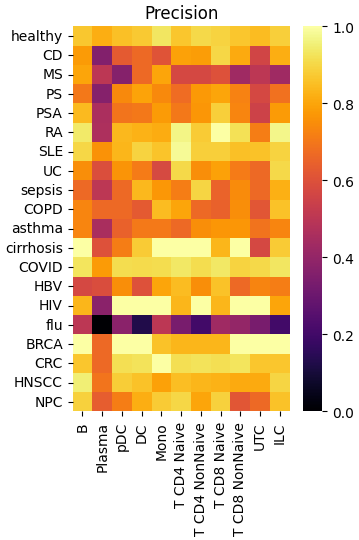

In [ ]:
data = cell_type_precision.query("cell_type != 'Majority vote'").pivot(columns='disease_true', index = 'cell_type', values = 'precision').T.fillna(0)

plt.figure(figsize=(3.5,5))

g = sns.heatmap(data.loc[disease_cat_ordDF.elementList[disease_cat_ordDF.elementList.isin(data.index.tolist())],
                cell_type_order],square=False,vmin=0,vmax=1,cmap='inferno')

g.set_xticks(g.get_xticks(), [t.get_text().replace('_',' ') for t in g.get_xticklabels()])

g.set_title('Precision')
g.set_xlabel("")
g.set_ylabel("")

plt.savefig(here(f"03_downstream_analysis/09_patient_classifier/5foldCV/results/figures/clusterMap_PRECISION_CTxDisease_noMV.pdf"),
dpi=300,
bbox_inches='tight',
pad_inches=0.1
)

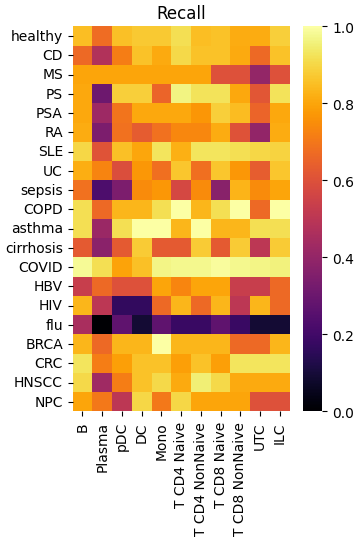

In [ ]:
data = cell_type_recall.query("cell_type != 'Majority vote'").pivot(columns='disease_true', index = 'cell_type', values = 'recall').T.fillna(0)

plt.figure(figsize=(3.5,5))

g = sns.heatmap(data.loc[disease_cat_ordDF.elementList[disease_cat_ordDF.elementList.isin(data.index.tolist())],
                cell_type_order],square=False,vmin=0,vmax=1,cmap='inferno')

g.set_xticks(g.get_xticks(), [t.get_text().replace('_',' ') for t in g.get_xticklabels()])

g.set_title('Recall')
g.set_xlabel("")
g.set_ylabel("")

plt.savefig(here(f"03_downstream_analysis/09_patient_classifier/5foldCV/results/figures/clusterMap_RECALL_CTxDisease_noMV.pdf"),
dpi=300,
bbox_inches='tight',
pad_inches=0.1
)

### Table with F1, precision, recall, and accuracy score per class

In [40]:
MetricsDF = getClassMetricsDF(data = labelsMelt, 
                              y_true_cn='disease_true', y_pred_cn='disease_pred', cell_type_cn='cell_type', 
                              disease_list=list(diseases_palette.keys()), 
                              include_aggregated=False)

In [ ]:
with pd.ExcelWriter(here('03_downstream_analysis/metricXdisease.xlsx'), mode = 'a') as writer:  
    MetricsDF.to_excel(writer, sheet_name='patientClassifier_5FCV', index_label=None, index=False)

### Confusion Matrix

#### Functions

In [48]:
# Computing the confusion matrix
def getConfusionMatrix(predTestDF = None, predCol = 'y_pred', gtCol = 'y_test', normalize='columns'):

    # normalize could be False, 'rows', or 'columns' (default).
    
    import pandas as pd

    if normalize == False:
        confusionMatrix = pd.crosstab(predTestDF[predCol], predTestDF[gtCol], dropna=False)
    else:
        confusionMatrix = pd.crosstab(predTestDF[predCol], predTestDF[gtCol], normalize=normalize, dropna=False)

    if confusionMatrix.shape[0] < confusionMatrix.shape[1]:
        for d in np.setdiff1d(confusionMatrix.columns.tolist(), confusionMatrix.index.tolist()):
            confusionMatrix.loc[d,:] = 0
    elif confusionMatrix.shape[0] > confusionMatrix.shape[1]:
        for d in np.setdiff1d(confusionMatrix.index.tolist(),confusionMatrix.columns.tolist()):
            confusionMatrix[d] = 0   

    return(confusionMatrix)

In [49]:
def reorder_ConfMatrix(confusionMatrix=None, elementList = None):

    confusionMatrix = confusionMatrix.reindex(elementList, axis=0).reindex(elementList, axis=1)

    return(confusionMatrix)

In [50]:
def mask_entries(confusionMatrix=None, lowerThan = 0, cmap='viridis'):
    confusionMatrix_nan = confusionMatrix.copy()
    confusionMatrix_nan[confusionMatrix_nan <= lowerThan] = np.nan
    return(confusionMatrix_nan)
    

#### Changing the PyComplexHeatmap code

https://dingwb.github.io/PyComplexHeatmap/build/html/notebooks/composite_heatmaps.html#Composite-two-heatmaps-horizontally-for-mouse-DNA-methylation-array-dataset

The following change is required to avoid reordering columns and rows. So, disease in the same category are close to each others

In [51]:
def _reorder_rows(self):
    self.row_split_dendrogram = False
    if self.verbose >= 1:
        print("Reordering rows..")
    if self.row_split is None and self.row_cluster:
        self.calculate_row_dendrograms(
            self.data2d
        )  # xind=self.dendrogram_row.reordered_ind
        self.row_order = [
            self.dendrogram_row.dendrogram["ivl"]
        ]  # self.data2d.iloc[:, xind].columns.tolist()
        return None
    elif isinstance(self.row_split, int) and self.row_cluster:
        self.calculate_row_dendrograms(self.data2d)
        self.row_clusters = (
            pd.Series(
                hierarchy.fcluster(
                    self.dendrogram_row.linkage,
                    t=self.row_split,
                    criterion="maxclust",
                ),
                index=self.data2d.index.tolist(),
            )
            .to_frame(name="cluster")
            .groupby("cluster")
            .apply(lambda x: x.index.tolist())
            .to_dict()
        )
        # index=self.dendrogram_row.dendrogram['ivl']).to_frame(name='cluster')

    elif isinstance(self.row_split, (pd.Series, pd.DataFrame)):
        if isinstance(self.row_split, pd.Series):
            self.row_split = self.row_split.to_frame(name=self.row_split.name)
        cols = self.row_split.columns.tolist()
        row_clusters = self.row_split.groupby(cols, sort=False).apply(
            lambda x: x.index.tolist()
        )
        if self.row_split_order is None:
            self.row_split_order = row_clusters.index.tolist()
        elif self.row_split_order == 'cluster_between_groups':
            mat=pd.concat([
                self.data2d.loc[rows].mean() for rows in row_clusters.tolist()],
                          axis=1).T #columns are original columns
            mat.index=row_clusters.index.tolist()
            sizes=row_clusters.apply(lambda x:len(x)).tolist()
            self.calculate_row_dendrograms(mat,sizes=sizes)
            self.row_split_order = self.dendrogram_row.dendrogram["ivl"]
            self.row_split_dendrogram=self.dendrogram_row
        self.row_clusters = row_clusters.loc[self.row_split_order].to_dict()
    elif not self.row_cluster:
        self.row_order = [self.data2d.index.tolist()]
        return None
    else:
        raise TypeError("row_split must be integar or dataframe or series")

    self.row_order = []
    self.dendrogram_rows = []
    for i, cluster in enumerate(self.row_clusters):
        rows = self.row_clusters[cluster]
        if len(rows) <= 1:
            self.row_order.append(rows)
            self.dendrogram_rows.append(None)
            continue
        if self.row_cluster: #cluster within groups
            self.calculate_row_dendrograms(self.data2d.loc[rows])
            self.dendrogram_rows.append(self.dendrogram_row)
            self.row_order.append(self.dendrogram_row.dendrogram["ivl"])
        else:
            self.row_order.append(rows)

def _reorder_cols(self):
    self.col_split_dendrogram=False
    if self.verbose >= 1:
        print("Reordering cols..")
    if self.col_split is None and self.col_cluster:
        self.calculate_col_dendrograms(self.data2d)
        self.col_order = [
            self.dendrogram_col.dendrogram["ivl"]
        ]  # self.data2d.iloc[:, xind].columns.tolist()
        return None
    elif isinstance(self.col_split, int) and self.col_cluster:
        self.calculate_col_dendrograms(self.data2d)
        self.col_clusters = (
            pd.Series(
                hierarchy.fcluster(
                    self.dendrogram_col.linkage,
                    t=self.col_split,
                    criterion="maxclust",
                ),
                index=self.data2d.columns.tolist(),
            )
            .to_frame(name="cluster")
            .groupby("cluster")
            .apply(lambda x: x.index.tolist())
            .to_dict()
        )
        # index=self.dendrogram_col.dendrogram['ivl']).to_frame(name='cluster')

    elif isinstance(self.col_split, (pd.Series, pd.DataFrame)):
        if isinstance(self.col_split, pd.Series):
            self.col_split = self.col_split.to_frame(name=self.col_split.name)
        cols = self.col_split.columns.tolist()
        col_clusters = self.col_split.groupby(cols, sort=False).apply(
            lambda x: x.index.tolist()
        )
        if self.col_split_order is None:
            self.col_split_order = col_clusters.index.tolist()
        elif self.col_split_order == 'cluster_between_groups':
            mat = pd.concat([
                self.data2d.loc[:,cols].mean(axis=1) for cols in col_clusters.tolist()],
                axis=1)  # index are original rows labels
            mat.columns = col_clusters.index.tolist()
            sizes = col_clusters.apply(lambda x: len(x)).tolist()
            self.calculate_col_dendrograms(mat, sizes=sizes)
            self.col_split_order = self.dendrogram_col.dendrogram["ivl"]
            self.col_split_dendrogram = self.dendrogram_col
        self.col_clusters = col_clusters.loc[self.col_split_order].to_dict()
    elif not self.col_cluster:
        self.col_order = [self.data2d.columns.tolist()]
        return None
    else:
        raise TypeError("row_split must be integar or dataframe or series")

    self.col_order = []
    self.dendrogram_cols = []
    for i, cluster in enumerate(self.col_clusters):
        cols = self.col_clusters[cluster]
        if len(cols) <= 1:
            self.col_order.append(cols)
            self.dendrogram_cols.append(None)
            continue
        if self.col_cluster:
            self.calculate_col_dendrograms(self.data2d.loc[:, cols])
            self.dendrogram_cols.append(self.dendrogram_col)
            self.col_order.append(self.dendrogram_col.dendrogram["ivl"])
        else:
            self.col_order.append(cols)

def plot_matrix(self, row_order, col_order):
    col_order=row_order.copy()
    if self.verbose >= 1:
        print("Plotting matrix..")
    nrows = len(row_order)
    ncols = len(col_order)
    self.wspace = (
        self.col_split_gap
        * mm2inch
        * self.ax.figure.dpi
        / (self.ax_heatmap.get_window_extent().width / ncols)
    )  # 1mm=mm2inch inch
    self.hspace = (
        self.row_split_gap
        * mm2inch
        * self.ax.figure.dpi
        / (self.ax_heatmap.get_window_extent().height / nrows)
    )  # height
    self.heatmap_gs = matplotlib.gridspec.GridSpecFromSubplotSpec(
        nrows,
        ncols,
        hspace=self.hspace,
        wspace=self.wspace,
        subplot_spec=self.gs[1, 1],
        height_ratios=[len(rows) for rows in row_order],
        width_ratios=[len(cols) for cols in col_order],
    )

    annot = self.kwargs.pop("annot", None)
    if annot is None or annot is False:
        pass
    else:
        if isinstance(annot, bool):
            annot_data = self.data2d
        else:
            annot_data = annot.copy()
            if annot_data.shape != self.data2d.shape:
                err = "`data` and `annot` must have same shape."
                raise ValueError(err)

    self.heatmap_axes = np.empty(shape=(nrows, ncols), dtype=object)
    # if nrows > 1 or ncols > 1:
    self.ax_heatmap.set_axis_off()
    for i, rows in enumerate(row_order):
        for j, cols in enumerate(col_order):
            # print(i,j)
            ax1 = self.ax_heatmap.figure.add_subplot(
                self.heatmap_gs[i, j],
                sharex=self.heatmap_axes[0, j],
                sharey=self.heatmap_axes[i, 0],
            )
            ax1.set_xlim([0, len(rows)])
            ax1.set_ylim([0, len(cols)])
            annot1 = None if annot is None else annot_data.loc[rows, cols]
            # heatmap(self.data2d.loc[rows, cols], ax=ax1, cbar=False, cmap=self.cmap,
            #         cbar_kws=None, mask=self.mask.loc[rows, cols], rasterized=self.rasterized,
            #         xticklabels='auto', yticklabels='auto', annot=annot1, **self.kwargs)
            plot_heatmap(
                self.data2d.loc[rows, cols],
                ax=ax1,
                cmap=self.cmap,
                mask=self.mask.loc[rows, cols],
                rasterized=self.rasterized,
                xticklabels="auto",
                yticklabels="auto",
                annot=True,
                **self.kwargs
            )
            self.heatmap_axes[i, j] = ax1
            ax1.yaxis.label.set_visible(False)
            ax1.xaxis.label.set_visible(False)
            ax1.tick_params(
                left=False,
                right=False,
                labelleft=False,
                labelright=False,
                top=False,
                bottom=False,
                labeltop=False,
                labelbottom=False,
            )


In [52]:
ClusterMapPlotter._reorder_rows = _reorder_rows
ClusterMapPlotter._reorder_cols = _reorder_cols
# ClusterMapPlotter.plot_matrix = plot_matrix

In [53]:
MajorityVote_confusionMatrix = getConfusionMatrix(predTestDF= labelsMelt.query("cell_type == 'Majority vote'"), predCol = 'disease_pred', gtCol = 'disease_true', normalize='columns')
MajorityVote_confusionMatrix_ord = reorder_ConfMatrix(mask_entries(MajorityVote_confusionMatrix, lowerThan = -1), elementList=disease_cat_ordDF.elementList)

In [54]:
MajorityVote_confusionMatrix_ord[MajorityVote_confusionMatrix_ord == 0.0] = np.nan
MajorityVote_confusionMatrix_ord = MajorityVote_confusionMatrix_ord.dropna(how='all').dropna(how='all', axis=1).fillna(0)

In [55]:
# rows
rowConditions = MajorityVote_confusionMatrix_ord.index.tolist()
rowAnnDF = pd.DataFrame.from_dict({'disease_cat' : [diseaseCategories[c] for c in rowConditions], 'disease':rowConditions}).set_index('disease')
row_ann = HeatmapAnnotation(disease_group=anno_simple(rowAnnDF.disease_cat, colors=diseasesGroup_palette, rasterized=True, legend_kws={'color_text':False, 'labelcolor':'black'}),#, legend_kws  = {'title': 'Disease\ngroups'}), 
                            axis=0,verbose=0, label_kws={'text':None}, plot=False, legend=True)

# columns
colConditions = MajorityVote_confusionMatrix_ord.columns.tolist()
colAnnDF = pd.DataFrame.from_dict({'disease_cat' : [diseaseCategories[c] for c in colConditions], 'disease':colConditions}).set_index('disease')
col_ann = HeatmapAnnotation(disease_group=anno_simple(colAnnDF.disease_cat, colors=diseasesGroup_palette, rasterized=True, legend_kws={'color_text':False, 'labelcolor':'black'}),#, legend_kws  = {'title': 'Disease\ngroups'}), 
                            axis=1,verbose=0, label_kws={'text':None}, plot=False, legend=False)

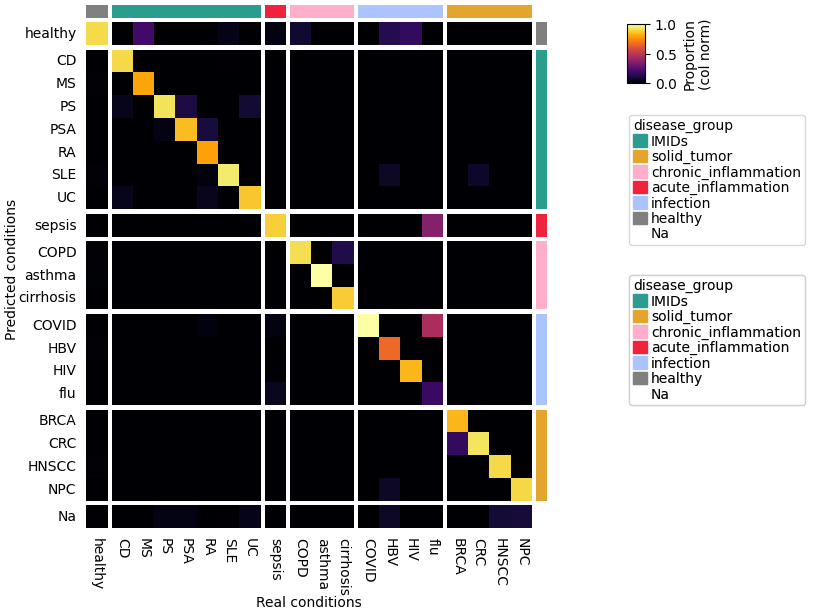

In [ ]:
plt.figure(figsize=(6,6))
cm = ClusterMapPlotter(data=MajorityVote_confusionMatrix_ord, 
                       right_annotation=row_ann, 
                       top_annotation=col_ann, 
                       row_split=rowAnnDF.disease_cat, #row_split_order=diseaseCatOrd,
                       col_split=colAnnDF.disease_cat, #col_split_order=diseaseCatOrd,
                       show_rownames=True,show_colnames=True, xlabel = 'Real conditions', ylabel = 'Predicted conditions',
                       plot=True, fmt=None,
                       row_cluster=False, col_cluster=False, standard_scale = None,
                       row_dendrogram=False,col_dendrogram=False, verbose=False,
                       cmap='inferno', rasterized=False, row_split_gap=1, col_split_gap=1, legend=True, label = 'Proportion\n(col norm)', legend_vpad=5,
                       vmax = 1, vmin = 0)


plt.savefig(here(f"03_downstream_analysis/09_patient_classifier/5foldCV/results/figures/MajorityVote_confusionMatrix.pdf"),
dpi=300,
bbox_inches='tight',
pad_inches=0.1
)

In [57]:
MajorityVote_confusionMatrix_ord.loc['flu','flu']

0.18181818181818182

In [58]:
from sklearn.metrics import accuracy_score

In [59]:
MVdf = labelsMelt.query("cell_type == 'Majority vote'")

WAcc_MVxDisease = {}
F1_MVxDisease = {}
Precision_MVxDisease = {}
Recall_MVxDisease = {}


for s in MVdf.SPLIT.unique():
    WAcc_MVxDisease[s] = {}
    Precision_MVxDisease[s] = {}
    Recall_MVxDisease[s] = {}
    
    for d in MVdf.disease_true.unique():
        #BAS over binarized data 
        WAcc_MVxDisease[s][d] = balanced_accuracy_score(y_true=MVdf.query("SPLIT == @s").disease_true == d,
                                                       y_pred=MVdf.query("SPLIT == @s").disease_pred == d)
        
        F1_MVxDisease[s] = f1_score(y_true=MVdf.query("SPLIT == @s").disease_true,
                                     y_pred=MVdf.query("SPLIT == @s").disease_pred,
                                     labels = MVdf.disease_true.unique(),average=None)
        
        Precision_MVxDisease[s] = precision_score(y_true=MVdf.query("SPLIT == @s").disease_true,
                                                     y_pred=MVdf.query("SPLIT == @s").disease_pred, 
                                                  labels = MVdf.disease_true.unique(), average=None)

        Recall_MVxDisease[s] = recall_score(y_true=MVdf.query("SPLIT == @s").disease_true,
                                                     y_pred=MVdf.query("SPLIT == @s").disease_pred, 
                                                  labels = MVdf.disease_true.unique(), average=None)

In [60]:
WAcc_MVxDisease_DF = pd.DataFrame(WAcc_MVxDisease)
WAcc_MVxDisease_DF = WAcc_MVxDisease_DF.reset_index().melt(id_vars='index',value_name='score', var_name='SPLIT')
WAcc_MVxDisease_DF['metric'] = 'B_Acc'

F1_MVxDisease_DF = pd.DataFrame(F1_MVxDisease)
F1_MVxDisease_DF.index = MVdf.disease_true.unique()
F1_MVxDisease_DF = F1_MVxDisease_DF.reset_index().melt(id_vars='index',value_name='score', var_name='SPLIT')
F1_MVxDisease_DF['metric'] = 'F1'


Precision_MVxDisease_DF = pd.DataFrame(Precision_MVxDisease)
Precision_MVxDisease_DF.index = MVdf.disease_true.unique()
Precision_MVxDisease_DF = Precision_MVxDisease_DF.reset_index().melt(id_vars='index',value_name='score', var_name='SPLIT')
Precision_MVxDisease_DF['metric'] = 'Precision'


Recall_MVxDisease_DF = pd.DataFrame(Recall_MVxDisease)
Recall_MVxDisease_DF.index = MVdf.disease_true.unique()
Recall_MVxDisease_DF = Recall_MVxDisease_DF.reset_index().melt(id_vars='index',value_name='score', var_name='SPLIT')
Recall_MVxDisease_DF['metric'] = 'Recall'

MVxDisease_DF =pd.concat([WAcc_MVxDisease_DF,F1_MVxDisease_DF,Precision_MVxDisease_DF,Recall_MVxDisease_DF], axis=0, ignore_index=True)
MVxDisease_DF.rename({'index':'disease'}, axis=1, inplace=True)
MVxDisease_DF

,disease,SPLIT,score,metric
0,COVID,0,0.993103,B_Acc
1,healthy,0,0.950292,B_Acc
2,sepsis,0,0.993789,B_Acc
3,flu,0,0.500000,B_Acc
4,HNSCC,0,1.000000,B_Acc
...,...,...,...,...
395,cirrhosis,4,1.000000,Recall
396,CRC,4,0.666667,Recall
397,MS,4,1.000000,Recall
398,HIV,4,0.000000,Recall


In [61]:
Recall_MVxDisease_DF.query("index == 'healthy'")

,index,SPLIT,score,metric
1,healthy,0,0.944444,Recall
21,healthy,1,0.944444,Recall
41,healthy,2,0.907407,Recall
61,healthy,3,0.888889,Recall
81,healthy,4,0.851852,Recall


In [62]:
Precision_MVxDisease_DF.query("index == 'healthy'")

,index,SPLIT,score,metric
1,healthy,0,0.910714,Precision
21,healthy,1,0.980769,Precision
41,healthy,2,1.000000,Precision
61,healthy,3,0.941176,Precision
81,healthy,4,0.938776,Precision


In [64]:
precision_score(y_true=MVdf.disease_true,y_pred=MVdf.disease_pred, labels = MVdf.disease_true.unique(), average=None)

array([0.94354839, 0.95330739, 0.86111111, 0.5       , 0.86363636,
       0.9       , 0.94366197, 0.86363636, 0.95      , 0.77419355,
       1.        , 0.81481481, 0.75      , 0.73333333, 1.        ,
       1.        , 0.92857143, 0.57142857, 1.        , 0.76923077])

In [65]:
MVdf.disease_true.unique()

array(['COVID', 'healthy', 'sepsis', 'flu', 'HNSCC', 'NPC', 'SLE', 'UC',
       'CD', 'PS', 'RA', 'PSA', 'asthma', 'COPD', 'BRCA', 'cirrhosis',
       'CRC', 'MS', 'HIV', 'HBV'], dtype=object)

In [66]:
recall_score(y_true=MVdf.disease_true,y_pred=MVdf.disease_pred, labels = MVdf.disease_true.unique(), average=None)

array([1.        , 0.90740741, 0.88571429, 0.18181818, 0.9047619 ,
       0.9       , 0.94366197, 0.86363636, 0.9047619 , 0.92307692,
       0.78947368, 0.84615385, 1.        , 0.91666667, 0.83333333,
       0.875     , 0.92857143, 0.8       , 0.83333333, 0.66666667])

In [67]:
countObs = (MVdf.groupby(['SPLIT','disease_true']).size().reset_index()
            .groupby(['disease_true']).mean()
            .drop('SPLIT',axis=1))

In [68]:
from customPalette import diseases_palette

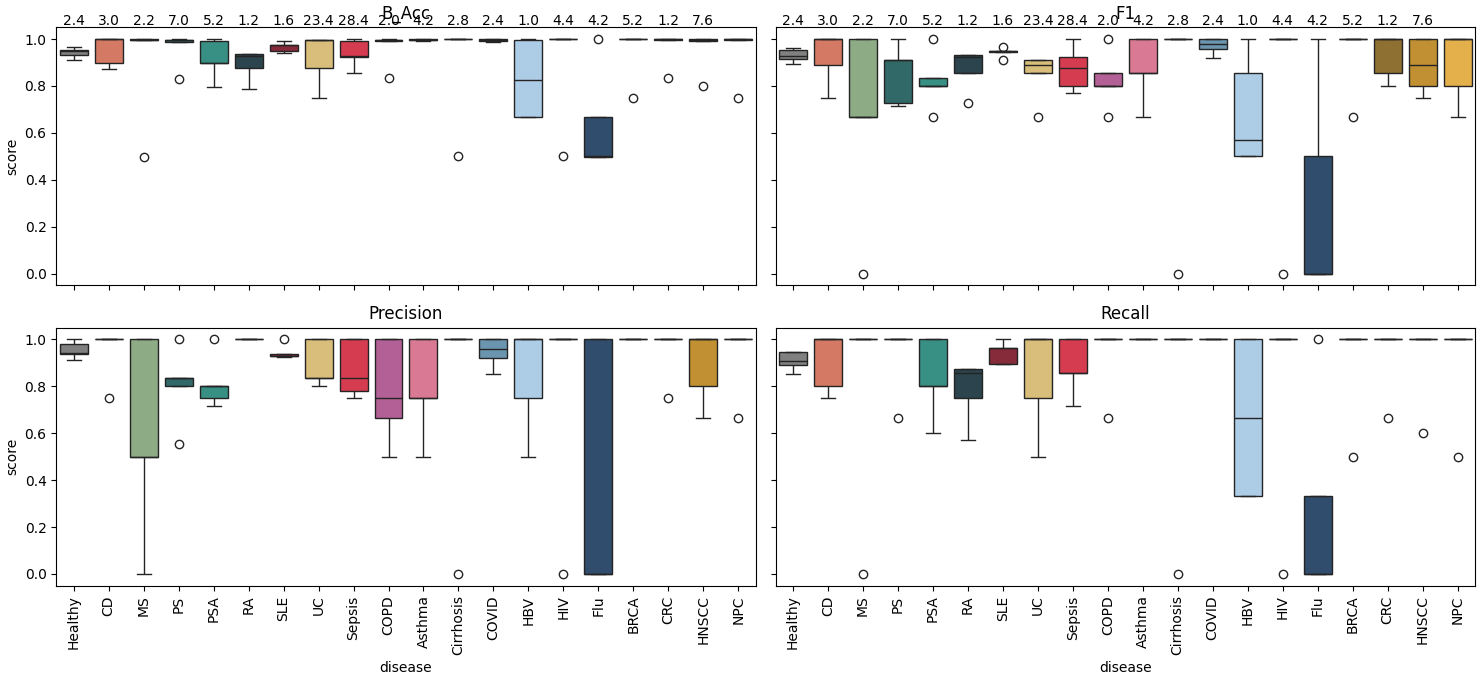

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming MVxDisease_DF, elementList, and countObs are defined earlier in the code.
# MVxDisease_DF = pd.DataFrame(...)
# elementList = [...]
# countObs = pd.DataFrame(...)

# Get unique metrics
metrics = MVxDisease_DF['metric'].unique()

# Create a subplot for each metric
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 7), sharex=True, sharey=True)

c=0
for ax, metric in zip(axs.flatten(), metrics):
    # Filter the DataFrame for the current metric
    df = MVxDisease_DF[MVxDisease_DF['metric'] == metric]
    
    # Create a boxplot
    g = sns.boxplot(x="disease", y="score", order=disease_cat_ordDF.query("elementList != 'Na'").elementList,
                    data=df, ax=ax, hue='disease', palette = diseases_palette)
    
    # Set title
    ax.set_title(f'{metric}')
    tickLabels = [[l for l in t.get_text().split()][0] for t in ax.get_xticklabels()]
    if len(tickLabels) > 0:
        ax.set_xticks(ax.get_xticks(), [l[0].upper() + l[1:] for l in tickLabels])

    ax.tick_params(axis='x',labelrotation=90)
    
    # Add the number of observations on top of the boxplots
    # ax.text(-1.4, 1.06, "mean(# sample)", horizontalalignment='center')
    if c<2:
        for i, d in enumerate(elementList):
            ax.text(i, 1.06, f'{countObs.loc[d,0]}', horizontalalignment='center')
    c += 1

# Adjust the layout
plt.tight_layout()
plt.savefig(here(f"03_downstream_analysis/09_patient_classifier/5foldCV/results/figures/MajorityVoting_boxplot_Waccuracy_F1_Precision_Recall.pdf"))
# Show the plot
plt.show()

